In [29]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import warnings

import _pickle as pickle

from astropy.table import Table, Column, vstack, join

import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from asap import io
from asap import smf 
from asap import config
from asap import fitting
from asap import ensemble
from asap import plotting
from asap import predictions
from asap.parameters import AsapParams
from asap.likelihood import ln_likelihood, ln_probability
from asap.predictions import (predict_mstar_basic, predict_smf, predict_mhalo,
                              predict_dsigma_profiles, make_model_predictions)

from dsigma import compute_ds as ds
from dsigma import jackknife as jk
from dsigma import covariance as cov
from dsigma.stack_ds import stack_delta_sigma, batch_delta_sigma
from dsigma.plots import show_delta_sigma_profiles, show_r_delta_sigma, show_single_profile

plt.rc('text', usetex=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
def prepare_catalog_for_acf(catalog, logm='logm_max', object_id='object_id', ra='ra', dec='dec',
                            redshift='z_best', min_logm=None):
    """Prepare the HSC catalog for awesome cluster finder."""
    # Make a copy of the file
    cat_use = copy.deepcopy(catalog)

    # Add a Mstar column. Notice that this is not the logM*, but just M*
    cat_use.add_column(Column(data=(10.0 ** cat_use[logm]), name='Mstar'))

    # Normalize some column names
    if object_id is not 'id':
        cat_use.rename_column(object_id, 'id')
    if ra is not 'ra':
        cat_use.renmae_column(ra, 'ra')
    if dec is not 'dec':
        cat_use.renmae_column(dec, 'dec')
    if redshift is not 'z':
        cat_use.rename_column(redshift, 'z')
    
    # Add index array if necessary
    if 'index' not in cat_use.colnames:
        cat_use.add_column(Column(data=np.arange(len(cat_use)), name='index'))

    # Make a mass cut if necessary
    if min_logm:
        cat_use = cat_use[cat_use[logm] >= min_logm]
        print("# Keep {} galaxies with {} >= {}".format(len(cat_use), logm, min_logm))

    # Only keep the useful columns
    return cat_use['id', 'ra', 'dec', 'z', 'Mstar'].as_array()


def stack_with_mask(lens_ds, lens_data, mask_use, rand_ds=None, rand_data=None,
                    n_boots=10000, n_jobs=4, z_bins=8, selection_bias=True, 
                    weight_field='weight'):
    """Stack the DeltaSigma profiles for the selected lenses."""
    lens_ds_use, lens_data_use = lens_ds[mask_use], lens_data[mask_use]

    # Get the stacked profile
    dsig_all, dsig_boot, dsig_jk = cov.get_bootstrap_samples_dsigma(
        lens_ds_use, rand_ds, lens_data_use, rand_data, n_boots=n_boots, n_jobs=n_jobs, 
        z_bins=z_bins, selection_bias=selection_bias, weight_field=weight_field, 
        use_boost=False)

    # Get the covariance matrix
    dsig_cov = np.cov(dsig_boot, rowvar=False)

    # Use the diagnoal terms as uncertainties
    dsig_err = np.sqrt(np.diag(dsig_cov))
    
    return dsig_all, dsig_err

## Predict Weak Lensing DeltaSigma Profiles for HSC Galaxies in a Halo Mass Bin

### Get the S16A lensing sample and random galaxies

* `lens_data` is the `npy` catalog for all the massive galaxies
* `rand_data` is the random catalog with 500k objects.
* `lens_pre` and `rand_pre` are the pre-computed individual lensing pairs.
    - `lens_ds`, `rand_ds` are the results from lensing pre-compute.
    - `radial_bins` is the definitions of radial bins of DSigma profiles.
* `lens_mass` is the lens catalog with a lot of additonal information. 
* **Notice**: `lens_mass` and `lens_ds` have corresponding items, so don't mess up the order.

In [2]:
wl_dir = '/Users/song/data/massive/dr16a/s16a_massive_dsig'

# Lens data
lens_data = np.load(os.path.join(wl_dir, 'lens/s16a_massive_lens_prep_new.npy'))
rand_data = np.load(os.path.join(wl_dir, 'random/s16a_random_500k_prep_new.npy'))

# Pre-compute results
# Medium selection
lens_pre = np.load(os.path.join(wl_dir, 'results/s16a_massive_lens_basic_dsig_pre.npz'))
rand_pre = np.load(os.path.join(wl_dir, 'results/s16a_massive_rand_basic_dsig_pre.npz'))

print(len(lens_data), len(lens_pre['delta_sigma']), len(rand_pre['delta_sigma']))

ds.assert_precompute_catalog_consistent(lens_pre, lens_data)
ds.assert_lens_rand_consistent(lens_pre, rand_pre)

# Number of Jackknife fiedls
njackknife_fields = 31

# Get the pre-compute deltaSigma data, radial bins
lens_ds, radial_bins = lens_pre['delta_sigma'], lens_pre['radial_bins']
rand_ds = rand_pre["delta_sigma"]

lens_ds, rand_ds = jk.add_jackknife_both(lens_ds, rand_ds, njackknife_fields)

# The cross-match is done outside 
# The astropy.table.join seems to change the order of the table.
lens_mass = Table.read(os.path.join(wl_dir, 's16a_massive_lens_prep_cog_mask.fits'))

assert np.all(lens_mass['object_id'] == lens_data['object_id'])

38653 38653 500000


In [12]:
# Add an index array, so that we won't mess up with the order
lens_mass.add_column(Column(name='index', data=np.arange(len(lens_mass))))

#### A basic quality cut for the massive galaxies

* These empirical cuts make sure the galaxy has a useful 1-D profile

In [4]:
quality_mask = ((lens_mass['logm_5'] >= 10.00) & (lens_mass['logm_5'] <= 11.52) &
                (lens_mass['logm_10'] >= 10.47) & (lens_mass['logm_10'] <= 11.72) &
                lens_mass['clean_photometry'] & lens_mass['cog_mask'])

print(quality_mask.sum(), len(lens_data))

37945 38653


#### Try to use a very simple method to exclude satellites

* This is based on the `awesome` cluster finder from Christopher Bradshaw

##### "Largest Central" method

* Under `acf.cluster_finder.largest_centrals()`
* Format is:
```python
input_catalog, memberships = largest_centrals(input_catalog, cylinder_radius, cylinder_half_length)
```
* Both `cylinder_radius` and `cylinder_half_length` are in unit of Mpc and depen on the cosmology model.
* The `membership` catalog has three columns: `id`, `cluster_num`, `is_central`.
* For observations, we need to have these columns: `id`, `ra`, `dec`, `z`, `Mstar`.

In [65]:
import awesome_cluster_finder as acf

# `acf` now will automatically read in a config file for simulation, we can ignore that.
# Just make sure we are in the observation mode
acf.config.use = 'observation'

In [66]:
lens_acf = prepare_catalog_for_acf(lens_mass, logm='logm_max', object_id='index', redshift='z')

lens_acf_sorted, lens_acf_mem = acf.cluster_finder.largest_centrals(lens_acf, 1.0, 20.)

print("# There are {} central galaxies".format(lens_acf_mem['is_central'].sum()))

# There are 30065 central galaxies


In [67]:
lens_acf_result = join(Table(lens_acf_sorted), Table(lens_acf_mem), keys='id', join_type='inner')

central_mask = (lens_acf_result['is_central'] > 0)

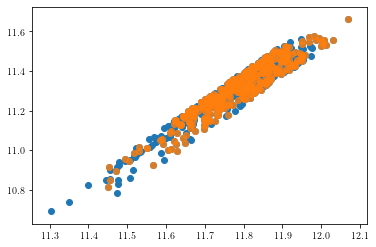

In [83]:
plt.scatter(lens_mass['logm_max'][mask_3], lens_mass['logm_10'][mask_3])
plt.scatter(lens_mass['logm_max'][mask_3_cen], lens_mass['logm_10'][mask_3_cen], alpha=0.8)

### Assign halo mass to HSC galaxies

#### Using Mhalo-Mmax-M10kpc plane

* `13.6826 + 3.541 * (logm_max - 11.71) - 2.542 * (logm_10 - 11.33)`

In [75]:
logmh_plane = 13.6826 + 3.541 * (lens_mass['logm_max'] - 11.71) - 2.542 * (lens_mass['logm_10'] - 11.33)

#lens_mass.remove_column('logmh_plane')
lens_mass.add_column(Column(data=logmh_plane, name='logmh_plane'))

#### Get the DSigma profiles for all galaxies in the bin

In [76]:
mask_1 = ((lens_mass['logmh_plane'] >= 13.00) & (lens_mass['logmh_plane'] < 13.42) &
          (lens_mass['logm_max'] >= 11.2) & quality_mask)

mask_2 = ((lens_mass['logmh_plane'] >= 13.42) & (lens_mass['logmh_plane'] < 13.83) &
          (lens_mass['logm_max'] >= 11.2) & quality_mask)

mask_3 = ((lens_mass['logmh_plane'] >= 13.83) & (lens_mass['logmh_plane'] < 14.25) &
          (lens_mass['logm_max'] >= 11.2) & quality_mask)

print(mask_1.sum(), mask_2.sum(), mask_3.sum())

dsig_1, err_1 = stack_with_mask(
    lens_ds, lens_data, mask_1, rand_ds=rand_ds, rand_data=rand_data,
    n_boots=10000, n_jobs=4, z_bins=8, selection_bias=True, 
    weight_field='weight')

dsig_2, err_2 = stack_with_mask(
    lens_ds, lens_data, mask_2, rand_ds=rand_ds, rand_data=rand_data,
    n_boots=10000, n_jobs=4, z_bins=8, selection_bias=True, 
    weight_field='weight')

dsig_3, err_3 = stack_with_mask(
    lens_ds, lens_data, mask_3, rand_ds=rand_ds, rand_data=rand_data,
    n_boots=10000, n_jobs=4, z_bins=8, selection_bias=True, 
    weight_field='weight')

10131 2956 621


In [84]:
np.savez('asap_hsc_mvir_predict_1906_bin1.npz', rmpc=radial_bins, 
         dsigma=dsig_1, err=err_1)

np.savez('asap_hsc_mvir_predict_1906_bin2.npz', rmpc=radial_bins, 
         dsigma=dsig_2, err=err_2)

np.savez('asap_hsc_mvir_predict_1906_bin3.npz', rmpc=radial_bins, 
         dsigma=dsig_3, err=err_3)

#### Get the DSigma for "centrals" only

* TODO: there is something weird

In [81]:
mask_1_cen = ((lens_mass['logmh_plane'] >= 13.00) & (lens_mass['logmh_plane'] < 13.42) &
              (lens_mass['logm_max'] >= 11.2) & quality_mask & ~central_mask)

mask_2_cen = ((lens_mass['logmh_plane'] >= 13.42) & (lens_mass['logmh_plane'] < 13.83) &
              (lens_mass['logm_max'] >= 11.2) & quality_mask & ~central_mask)

mask_3_cen = ((lens_mass['logmh_plane'] >= 13.83) & (lens_mass['logmh_plane'] < 14.25) &
              (lens_mass['logm_max'] >= 11.2) & quality_mask & ~central_mask)

print(mask_1_cen.sum(), mask_2_cen.sum(), mask_3_cen.sum())

dsig_1_cen, err_1_cen = stack_with_mask(
    lens_ds, lens_data, mask_1_cen, rand_ds=rand_ds, rand_data=rand_data,
    n_boots=10000, n_jobs=4, z_bins=8, selection_bias=True, 
    weight_field='weight')

dsig_2_cen, err_2_cen = stack_with_mask(
    lens_ds, lens_data, mask_2_cen, rand_ds=rand_ds, rand_data=rand_data,
    n_boots=10000, n_jobs=4, z_bins=8, selection_bias=True, 
    weight_field='weight')

dsig_3_cen, err_3_cen = stack_with_mask(
    lens_ds, lens_data, mask_3_cen, rand_ds=rand_ds, rand_data=rand_data,
    n_boots=10000, n_jobs=4, z_bins=8, selection_bias=True, 
    weight_field='weight')

3118 1260 389


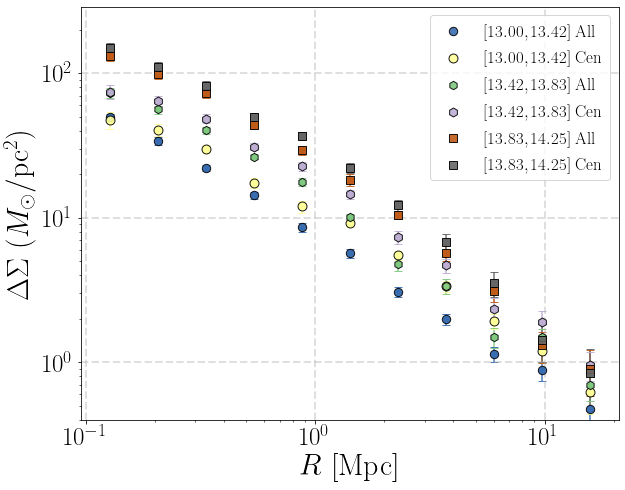

In [82]:
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.16, right=0.99, bottom=0.13, top=0.95,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

ax1 = show_single_profile(radial_bins, dsig_1, dsigma_err=err_1,
                          ax=ax1, s=70, marker='o', c=plt.cm.Accent(0.5), 
                          label=r'$[13.00, 13.42]\ \rm All$')

ax1 = show_single_profile(radial_bins, dsig_1_cen, dsigma_err=err_1_cen,
                          ax=ax1, s=80, marker='o', c=plt.cm.Accent(0.4), 
                          label=r'$[13.00, 13.42]\ \rm Cen$')

ax1 = show_single_profile(radial_bins, dsig_2, dsigma_err=err_2,
                          ax=ax1, s=70, marker='h', c=plt.cm.Accent(0.1), 
                          label=r'$[13.42, 13.83]\ \rm All$')

ax1 = show_single_profile(radial_bins, dsig_2_cen, dsigma_err=err_2_cen,
                          ax=ax1, s=80, marker='h', c=plt.cm.Accent(0.2), 
                          label=r'$[13.42, 13.83]\ \rm Cen$')

ax1 = show_single_profile(radial_bins, dsig_3, dsigma_err=err_3,
                          ax=ax1, s=70, marker='s', c=plt.cm.Accent(0.8), 
                          label=r'$[13.83, 14.25]\ \rm All$')

ax1 = show_single_profile(radial_bins, dsig_3_cen, dsigma_err=err_3_cen,
                          ax=ax1, s=80, marker='s', c=plt.cm.Accent(0.9), 
                          label=r'$[13.83, 14.25]\ \rm Cen$')

ax1.legend(loc='upper right', fontsize=17)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax1.set_ylim(0.4, 289)

_ = ax1.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
_ = ax1.set_ylabel(r'$\Delta\Sigma\ (M_{\odot}/\mathrm{pc}^2)$', fontsize=30)